In [18]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos desde el archivo
data = pd.read_excel('SystemData.xlsx', sheet_name='Sheet1')

# Asignar las series horarias a Ppv y PL
potencia_fotovoltaica = data['Ppv'].values
potencia_demanda = data['PL'].values
data

,hour,sun irradiance,load curve,Ppv,PL
0,1,0.0,0.675711,0.0,1013.565891
1,2,0.0,0.701550,0.0,1052.325581
2,3,0.0,0.683463,0.0,1025.193798
3,4,0.0,0.675711,0.0,1013.565891
4,5,0.0,0.682171,0.0,1023.255814
...,...,...,...,...,...
67,68,0.0,0.892876,0.0,1339.314341
68,69,0.0,0.774972,0.0,1162.458527
69,70,0.0,0.733215,0.0,1099.822093
70,71,0.0,0.725846,0.0,1088.768605


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-2600 CPU @ 3.40GHz, instruction set [SSE2|AVX]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2006 rows, 576 columns and 3360 nonzeros
Model fingerprint: 0x8b490ae6
Model has 360 quadratic objective terms
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [3e+01, 5e+01]
  QObjective range [2e-01, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+03]
Presolve removed 1508 rows and 2 columns
Presolve time: 0.01s
Presolved: 498 rows, 929 columns, 1851 nonzeros
Presolved model has 360 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.201e+03
 Factor NZ  : 6.702e+03 (roughly 1 MB of memory)
 Factor Ops : 9.867e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

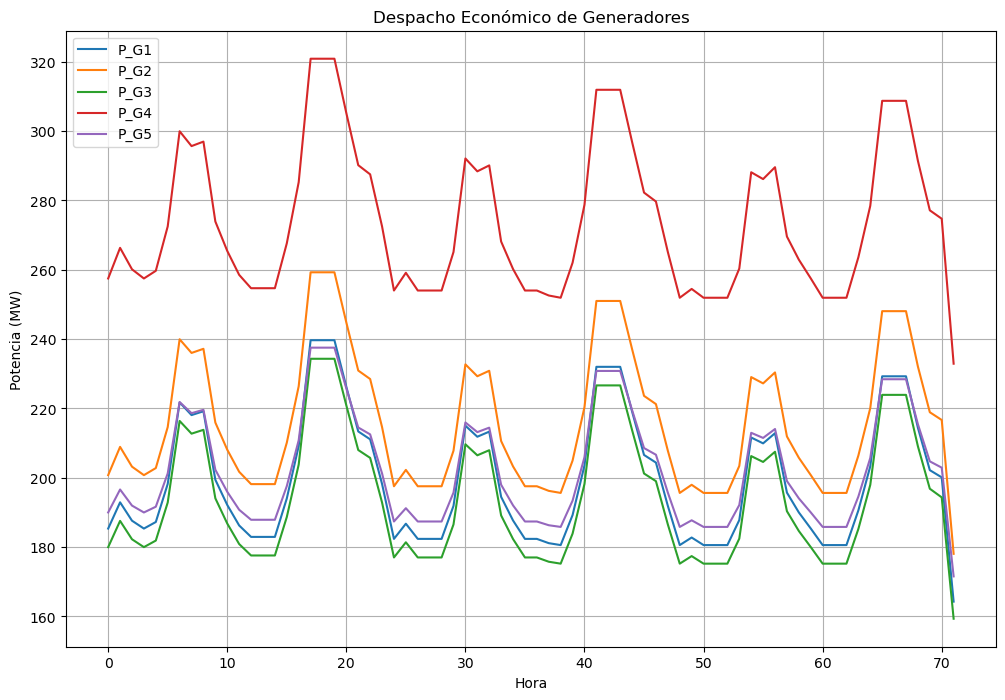

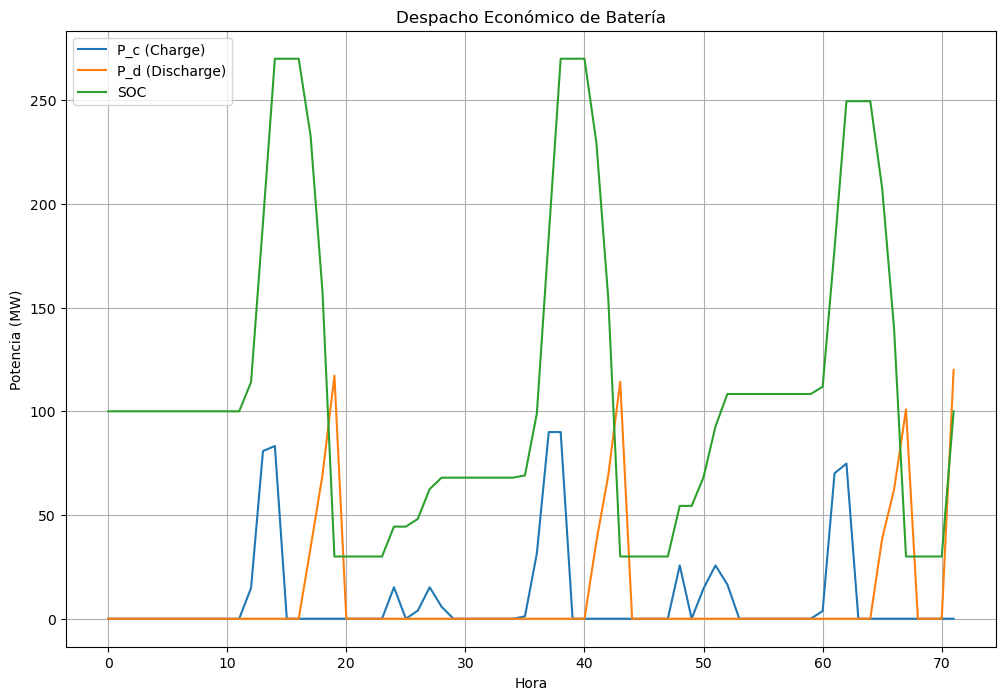

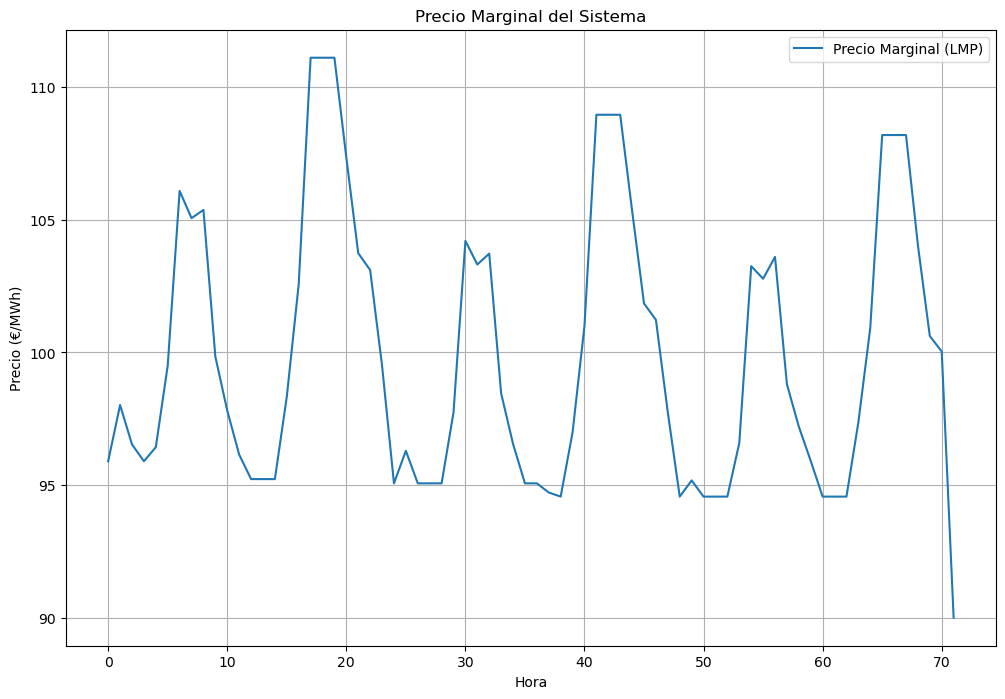

In [23]:
from gurobipy import Model, GRB, quicksum

# Crear el modelo
model = Model("Economic Dispatch")

# Parámetros
n_hours = len(potencia_demanda)  # Número de horas
n_units = 5  # Número de generadores térmicos
Pmin = [30, 25, 35, 25, 25]  # Potencias mínimas de los generadores
Pmax = [300, 390, 390, 360, 360]  # Potencias máximas de los generadores
Rup = [45, 35, 35, 55, 35]  # Rampas ascendentes
Rdown = [45, 45, 35, 45, 55]  # Rampas descendentes
eta_c = 0.95  # Eficiencia de carga
eta_d = 0.92  # Eficiencia de descarga
SOC_min = 0.1 * 300  # Mínimo SOC
SOC_max = 0.9 * 300  # Máximo SOC
Pmax_c = 0.3 * 300  # Potencia máxima de carga (300 MWh * 0.3 C-rate)
Pmax_d = 0.4 * 300  # Potencia máxima de descarga (300 MWh * 0.4 C-rate)
SOC_target = 100  # SOC objetivo al final del ciclo

# Variables de decisión
P_G = model.addVars(n_units, n_hours, name="P_G")  # Potencia generada por los térmicos
P_c = model.addVars(n_hours, name="P_c")  # Potencia de carga de la batería
P_d = model.addVars(n_hours, name="P_d")  # Potencia de descarga de la batería
SOC = model.addVars(n_hours, name="SOC")  # Estado de carga de la batería

# Función objetivo: minimizar el costo operativo (OPEX)
fixed_costs = [0.14, 0.13, 0.14, 0.12, 0.16]
cost_coeffs = [44.0, 43.7, 45.5, 34.1, 35.1]

OPEX = quicksum(
    quicksum(fixed_costs[i] * P_G[i, t] * P_G[i, t] + cost_coeffs[i] * P_G[i, t] for i in range(n_units))
    for t in range(n_hours)
)
model.setObjective(OPEX, GRB.MINIMIZE)

# Restricciones
# 1. Balance de potencia
for t in range(n_hours):
    model.addConstr(
        quicksum(P_G[i, t] for i in range(n_units)) + potencia_fotovoltaica[t] + P_d[t] == P_c[t] + potencia_demanda[t],
        name=f"balance_{t}"
    )

# 2. Restricciones de rampa
for i in range(n_units):
    for t in range(1, n_hours):
        model.addConstr(P_G[i, t] - P_G[i, t-1] <= Rup[i], name=f"ramp_up_{i}_{t}")
        model.addConstr(P_G[i, t-1] - P_G[i, t] <= Rdown[i], name=f"ramp_down_{i}_{t}")

# 3. Restricciones de SOC de la batería
model.addConstr(SOC[0] == SOC_target + P_c[0] * eta_c - P_d[0] / eta_d, name="SOC_initial")
for t in range(1, n_hours-1):
    model.addConstr(SOC[t] == SOC[t-1] + P_c[t] * eta_c - P_d[t] / eta_d, name=f"SOC_{t}")
model.addConstr(SOC[n_hours-1] == SOC_target, name="SOC_final")

# 4. Límites de potencia generada

for i in range(n_units):
    for t in range(n_hours):
        model.addConstr(P_G[i, t] >= Pmin[i], name=f"Pmin_{i}_{t}")
        model.addConstr(P_G[i, t] <= Pmax[i], name=f"Pmax_{i}_{t}")

# 5. Límites de carga y descarga de la batería
for t in range(n_hours):
    model.addConstr(P_c[t] >= 0, name=f"P_c_min_{t}")
    model.addConstr(P_c[t] <= Pmax_c, name=f"P_c_max_{t}")
    model.addConstr(P_d[t] >= 0, name=f"P_d_min_{t}")
    model.addConstr(P_d[t] <= Pmax_d, name=f"P_d_max_{t}")

# 6. Límites de SOC
for t in range(n_hours):
    model.addConstr(SOC[t] >= SOC_min, name=f"SOC_min_{t}")
    model.addConstr(SOC[t] <= SOC_max, name=f"SOC_max_{t}")

# Resolver el modelo
model.optimize()

# Verificar si la optimización fue exitosa
if model.status == GRB.OPTIMAL:
    print("Optimización completada con éxito.")
    # Extraer resultados
    P_G_values = model.getAttr('x', P_G)
    P_c_values = model.getAttr('x', P_c)
    P_d_values = model.getAttr('x', P_d)
    SOC_values = model.getAttr('x', SOC)
    LMP = [model.getConstrByName(f"balance_{t}").Pi for t in range(n_hours)]  # Precio marginal (LMP)
    
    # Crear DataFrame con los resultados
    results_df = pd.DataFrame({
        'Hour': range(n_hours),
        'P_G1': [P_G_values[0, t] for t in range(n_hours)],
        'P_G2': [P_G_values[1, t] for t in range(n_hours)],
        'P_G3': [P_G_values[2, t] for t in range(n_hours)],
        'P_G4': [P_G_values[3, t] for t in range(n_hours)],
        'P_G5': [P_G_values[4, t] for t in range(n_hours)],
        'P_c': [P_c_values[t] for t in range(n_hours)],
        'P_d': [P_d_values[t] for t in range(n_hours)],
        'SOC': [SOC_values[t] for t in range(n_hours)],
        'LMP': LMP
    })
    
    # Graficar el despacho económico por generadores
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Hour'], results_df['P_G1'], label='P_G1')
    plt.plot(results_df['Hour'], results_df['P_G2'], label='P_G2')
    plt.plot(results_df['Hour'], results_df['P_G3'], label='P_G3')
    plt.plot(results_df['Hour'], results_df['P_G4'], label='P_G4')
    plt.plot(results_df['Hour'], results_df['P_G5'], label='P_G5')
    plt.title('Despacho Económico de Generadores')
    plt.xlabel('Hora')
    plt.ylabel('Potencia (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el despacho económico por batería
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Hour'], results_df['P_c'], label='P_c (Charge)')
    plt.plot(results_df['Hour'], results_df['P_d'], label='P_d (Discharge)')
    plt.plot(results_df['Hour'], results_df['SOC'], label='SOC')
    plt.title('Despacho Económico de Batería')
    plt.xlabel('Hora')
    plt.ylabel('Potencia (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Graficar el precio marginal
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Hour'], results_df['LMP'], label='Precio Marginal (LMP)')
    plt.title('Precio Marginal del Sistema')
    plt.xlabel('Hora')
    plt.ylabel('Precio (€/MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se pudo encontrar una solución óptima.")

In [20]:
# Balance Económico
total_OPEX = sum(
    sum(fixed_costs[i] * P_G_values[i, t] * P_G_values[i, t] + cost_coeffs[i] * P_G_values[i, t] 
        for i in range(n_units)) 
    for t in range(n_hours)
)

total_ingresos = sum(LMP[t] * potencia_demanda[t] for t in range(n_hours))
beneficio_neto = total_ingresos - total_OPEX

# Mostrar resultados del balance económico
print(f"Balance Económico del Sistema:")
print(f"Costo Total de Operación (OPEX): {total_OPEX:.2f} €")
print(f"Ingresos Totales del Sistema: {total_ingresos:.2f} €")
print(f"Beneficio Neto del Sistema: {beneficio_neto:.2f} €")
print()

# Balance de Energía
energia_generada_termica = sum(
    sum(P_G_values[i, t] for i in range(n_units))
    for t in range(n_hours)
)

energia_generada_fotovoltaica = sum(potencia_fotovoltaica)

energia_cargada_bateria = sum(P_c_values[t]  for t in range(n_hours))
energia_descargada_bateria = sum(P_d_values[t]  for t in range(n_hours))

energia_demandada_total = sum(potencia_demanda)

# Verificación del balance de energía
energia_total_generada = energia_generada_termica + energia_generada_fotovoltaica
energia_balanceada = energia_total_generada + energia_descargada_bateria - energia_cargada_bateria

print(f"Balance de Energía del Sistema:")
print(f"Energía Generada por Generadores Térmicos: {energia_generada_termica:.2f} MWh")
print(f"Energía Generada por Planta Fotovoltaica: {energia_generada_fotovoltaica:.2f} MWh")
print(f"Energía Cargada en la Batería: {energia_cargada_bateria:.2f} MWh")
print(f"Energía Descargada de la Batería: {energia_descargada_bateria:.2f} MWh")
print(f"Energía Demandada Total: {energia_demandada_total:.2f} MWh")
print(f"Energía Total Generada: {energia_balanceada:.2f} MWh")
print()

# Verificación de balance
if abs(energia_balanceada - energia_demandada_total) < 1e-3:
    print("El balance de energía del sistema es correcto.")
else:
    print("Hay un desequilibrio en el balance de energía del sistema.")

Balance Económico del Sistema:
Costo Total de Operación (OPEX): 5487382.48 €
Ingresos Totales del Sistema: 8985552.06 €
Beneficio Neto del Sistema: 3498169.58 €

Balance de Energía del Sistema:
Energía Generada por Generadores Térmicos: 78193.16 MWh
Energía Generada por Planta Fotovoltaica: 11429.48 MWh
Energía Cargada en la Batería: 662.66 MWh
Energía Descargada de la Batería: 763.57 MWh
Energía Demandada Total: 89723.55 MWh
Energía Total Generada: 89723.55 MWh

El balance de energía del sistema es correcto.


In [21]:
# Crear el modelo sin batería
model_sin_bateria = Model("Economic Dispatch Sin Batería")

# Variables de decisión sin la batería
P_G_sin_bateria = model_sin_bateria.addVars(n_units, n_hours, name="P_G_sb")

# Función objetivo: minimizar el costo operativo (OPEX)
OPEX_sin_bateria = quicksum(
    quicksum(fixed_costs[i] * P_G_sin_bateria[i, t] * P_G_sin_bateria[i, t] +  cost_coeffs[i] * P_G_sin_bateria[i, t] for i in range(n_units))
    for t in range(n_hours)
)
model_sin_bateria.setObjective(OPEX_sin_bateria, GRB.MINIMIZE)

# Restricciones de balance de potencia sin batería
for t in range(n_hours):
    model_sin_bateria.addConstr(
        quicksum(P_G_sin_bateria[i, t] for i in range(n_units)) + potencia_fotovoltaica[t] == potencia_demanda[t],
        name=f"balance_sin_bateria_{t}"
    )
    
# Restricciones de rampas y límites de potencia generada
""""
for i in range(n_units):
    for t in range(1, n_hours):
        model_sin_bateria.addConstr(P_G_sin_bateria[i, t] - P_G_sin_bateria[i, t-1] <= Rup[i], name=f"ramp_up_sin_bateria_{i}_{t}")
        model_sin_bateria.addConstr(P_G_sin_bateria[i, t-1] - P_G_sin_bateria[i, t] <= Rdown[i], name=f"ramp_down_sin_bateria_{i}_{t}")
    for t in range(n_hours):
        model_sin_bateria.addConstr(P_G_sin_bateria[i, t] >= Pmin[i], name=f"Pmin_sin_bateria_{i}_{t}")
        model_sin_bateria.addConstr(P_G_sin_bateria[i, t] <= Pmax[i], name=f"Pmax_sin_bateria_{i}_{t}")
"""
# Resolver el modelo sin batería
model_sin_bateria.optimize()

# Verificar si la optimización fue exitosa
if model_sin_bateria.status == GRB.OPTIMAL:
    print("Optimización completada con éxito sin batería.")
    # Extraer resultados
    P_G_sin_bateria_values = model_sin_bateria.getAttr('x', P_G_sin_bateria)
    LMP_sin_bateria = [model_sin_bateria.getConstrByName(f"balance_sin_bateria_{t}").Pi for t in range(n_hours)]

    # Balance Económico sin batería
    total_OPEX_sin_bateria = sum(
        sum(fixed_costs[i] * P_G_sin_bateria_values[i, t] * P_G_sin_bateria_values[i, t] + cost_coeffs[i] * P_G_sin_bateria_values[i, t] 
            for i in range(n_units)) 
        for t in range(n_hours)
    )

    total_ingresos_sin_bateria = sum(LMP_sin_bateria[t] * potencia_demanda[t] for t in range(n_hours))
    total_ingresos_gen_sin_bateria = sum(LMP_sin_bateria[t] * (potencia_demanda[t]-potencia_fotovoltaica[t]) for t in range(n_hours))
    beneficio_neto_sin_bateria = total_ingresos_sin_bateria - total_OPEX_sin_bateria

    print(f"Ingresos totales sin batería : {total_ingresos_sin_bateria} €")

    # Comparar costos para la carga
    costo_total_con_bateria = total_OPEX
    costo_total_sin_bateria = total_OPEX_sin_bateria
    
    print(f"Costo total para la carga con batería: {costo_total_con_bateria:.2f} €")
    print(f"Costo total para la carga sin batería: {costo_total_sin_bateria:.2f} €")
    print(f"Beneficios totales sin batería : {beneficio_neto_sin_bateria} €")

    if costo_total_sin_bateria > costo_total_con_bateria:
        print("La carga paga más sin la batería.")
    else:
        print("La carga paga menos sin la batería.")



Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-2600 CPU @ 3.40GHz, instruction set [SSE2|AVX]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 72 rows, 360 columns and 360 nonzeros
Model fingerprint: 0xfd2d0d9f
Model has 360 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 5e+01]
  QObjective range [2e-01, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 1e+03]
Presolve time: 0.01s
Presolved: 72 rows, 360 columns, 360 nonzeros
Presolved model has 360 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 7.200e+01
 Factor Ops : 7.200e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.02686240e+08 -3.656

In [22]:
BESS = 380 # €/kWh
costo_BESS = BESS * 300 * 1000 # €/kWh * MWh = k€
beneficios_con_BESS = (costo_total_sin_bateria - costo_total_con_bateria)*4*12*10 # Beneficios en 10 años/ 115.69507111 años para retorno de inversión
print(f"CAPEX Batería: {costo_BESS} €")
print(f"Beneficio neto sin batería: {beneficios_con_BESS} €")
print(f"Ingresos totales sin batería: {total_ingresos_gen_sin_bateria} €")
if beneficios_con_BESS - costo_BESS > 0:
    print(f"Los beneficios son sufientes para cubrir el costo del BESS: {beneficios_con_BESS - costo_BESS} ")
else:
    print(f"Los beneficios no son sufientes para cubrir el costo del BESS: {beneficios_con_BESS - costo_BESS}")

CAPEX Batería: 114000000 €
Beneficio neto sin batería: 10317792.778051794 €
Ingresos totales sin batería: 7881861.646331504 €
Los beneficios no son sufientes para cubrir el costo del BESS: -103682207.2219482
